In [1]:
# |default_exp lit_model

# LitModel
> Lit model API

In [2]:
%load_ext autoreload
%autoreload 2


## Imports

In [3]:
# | export
from loguru import logger
from pytorch_lightning import LightningModule

import torch
import torch.nn as nn
from datetime import datetime, timedelta
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import os
from fastcore.all import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
try:
    from ple.loss import FocalLoss, BinaryFocalLoss
except Exception as e:
    FocalLoss, BinaryFocalLoss = None, None
import os.path as osp
from torch.optim.lr_scheduler import LambdaLR


## Schedulers

In [4]:
#| export
from typing import Any
class Scheduler:
    """ Parameter Scheduler Base Class
    A scheduler base class that can be used to schedule any optimizer parameter groups.

    Unlike the builtin PyTorch schedulers, this is intended to be consistently called
    * At the END of each epoch, before incrementing the epoch count, to calculate next epoch's value
    * At the END of each optimizer update, after incrementing the update count, to calculate next update's value

    The schedulers built on this should try to remain as stateless as possible (for simplicity).

    This family of schedulers is attempting to avoid the confusion of the meaning of 'last_epoch'
    and -1 values for special behaviour. All epoch and update counts must be tracked in the training
    code and explicitly passed in to the schedulers on the corresponding step or step_update call.

    Based on ideas from:
     * https://github.com/pytorch/fairseq/tree/master/fairseq/optim/lr_scheduler
     * https://github.com/allenai/allennlp/tree/master/allennlp/training/learning_rate_schedulers
    """

    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 param_group_field: str,
                 noise_range_t=None,
                 noise_type='normal',
                 noise_pct=0.67,
                 noise_std=1.0,
                 noise_seed=None,
                 initialize: bool = True) -> None:
        self.optimizer = optimizer
        self.param_group_field = param_group_field
        self._initial_param_group_field = f"initial_{param_group_field}"
        if initialize:
            for i, group in enumerate(self.optimizer.param_groups):
                if param_group_field not in group:
                    raise KeyError(f"{param_group_field} missing from param_groups[{i}]")
                group.setdefault(self._initial_param_group_field, group[param_group_field])
        else:
            for i, group in enumerate(self.optimizer.param_groups):
                if self._initial_param_group_field not in group:
                    raise KeyError(f"{self._initial_param_group_field} missing from param_groups[{i}]")
        self.base_values = [group[self._initial_param_group_field] for group in self.optimizer.param_groups]
        self.metric = None  # any point to having this for all?
        self.noise_range_t = noise_range_t
        self.noise_pct = noise_pct
        self.noise_type = noise_type
        self.noise_std = noise_std
        self.noise_seed = noise_seed if noise_seed is not None else 42
        self.update_groups(self.base_values)

    def state_dict(self) -> Dict[str, Any]:
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        self.__dict__.update(state_dict)

    def get_epoch_values(self, epoch: int):
        return None

    def get_update_values(self, num_updates: int):
        return None

    def step(self, epoch: int, metric: float = None) -> None:
        self.metric = metric
        values = self.get_epoch_values(epoch)
        if values is not None:
            values = self._add_noise(values, epoch)
            self.update_groups(values)

    def step_update(self, num_updates: int, metric: float = None):
        self.metric = metric
        values = self.get_update_values(num_updates)
        if values is not None:
            values = self._add_noise(values, num_updates)
            self.update_groups(values)

    def update_groups(self, values):
        if not isinstance(values, (list, tuple)):
            values = [values] * len(self.optimizer.param_groups)
        for param_group, value in zip(self.optimizer.param_groups, values):
            if 'lr_scale' in param_group:
                param_group[self.param_group_field] = value * param_group['lr_scale']
            else:
                param_group[self.param_group_field] = value

    def _add_noise(self, lrs, t):
        if self._is_apply_noise(t):
            noise = self._calculate_noise(t)
            lrs = [v + v * noise for v in lrs]
        return lrs

    def _is_apply_noise(self, t) -> bool:
        """Return True if scheduler in noise range."""
        apply_noise = False
        if self.noise_range_t is not None:
            if isinstance(self.noise_range_t, (list, tuple)):
                apply_noise = self.noise_range_t[0] <= t < self.noise_range_t[1]
            else:
                apply_noise = t >= self.noise_range_t
        return apply_noise

    def _calculate_noise(self, t) -> float:
        g = torch.Generator()
        g.manual_seed(self.noise_seed + t)
        if self.noise_type == 'normal':
            while True:
                # resample if noise out of percent limit, brute force but shouldn't spin much
                noise = torch.randn(1, generator=g).item()
                if abs(noise) < self.noise_pct:
                    return noise
        else:
            noise = 2 * (torch.rand(1, generator=g).item() - 0.5) * self.noise_pct
        return noise

In [5]:
#| export
class CosineLRScheduler(Scheduler):
    """
    Cosine decay with restarts.
    This is described in the paper https://arxiv.org/abs/1608.03983.

    Inspiration from
    https://github.com/allenai/allennlp/blob/master/allennlp/training/learning_rate_schedulers/cosine.py

    k-decay option based on `k-decay: A New Method For Learning Rate Schedule` - https://arxiv.org/abs/2004.05909
    """

    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 t_initial: int,
                 lr_min: float = 0.,
                 cycle_mul: float = 1.,
                 cycle_decay: float = 1.,
                 cycle_limit: int = 1,
                 warmup_t=0,
                 warmup_lr_init=0,
                 warmup_prefix=False,
                 t_in_epochs=True,
                 noise_range_t=None,
                 noise_pct=0.67,
                 noise_std=1.0,
                 noise_seed=42,
                 k_decay=1.0,
                 initialize=True) -> None:
        super().__init__(
            optimizer, param_group_field="lr",
            noise_range_t=noise_range_t, noise_pct=noise_pct, noise_std=noise_std, noise_seed=noise_seed,
            initialize=initialize)

        assert t_initial > 0
        assert lr_min >= 0
        if t_initial == 1 and cycle_mul == 1 and cycle_decay == 1:
            _logger.warning("Cosine annealing scheduler will have no effect on the learning "
                           "rate since t_initial = t_mul = eta_mul = 1.")
        self.t_initial = t_initial
        self.lr_min = lr_min
        self.cycle_mul = cycle_mul
        self.cycle_decay = cycle_decay
        self.cycle_limit = cycle_limit
        self.warmup_t = warmup_t
        self.warmup_lr_init = warmup_lr_init
        self.warmup_prefix = warmup_prefix
        self.t_in_epochs = t_in_epochs
        self.k_decay = k_decay
        if self.warmup_t:
            self.warmup_steps = [(v - warmup_lr_init) / self.warmup_t for v in self.base_values]
            super().update_groups(self.warmup_lr_init)
        else:
            self.warmup_steps = [1 for _ in self.base_values]

    def _get_lr(self, t):
        if t < self.warmup_t:
            lrs = [self.warmup_lr_init + t * s for s in self.warmup_steps]
        else:
            if self.warmup_prefix:
                t = t - self.warmup_t

            if self.cycle_mul != 1:
                i = math.floor(math.log(1 - t / self.t_initial * (1 - self.cycle_mul), self.cycle_mul))
                t_i = self.cycle_mul ** i * self.t_initial
                t_curr = t - (1 - self.cycle_mul ** i) / (1 - self.cycle_mul) * self.t_initial
            else:
                i = t // self.t_initial
                t_i = self.t_initial
                t_curr = t - (self.t_initial * i)

            gamma = self.cycle_decay ** i
            lr_max_values = [v * gamma for v in self.base_values]
            k = self.k_decay

            if i < self.cycle_limit:
                lrs = [
                    self.lr_min + 0.5 * (lr_max - self.lr_min) * (1 + math.cos(math.pi * t_curr ** k / t_i ** k))
                    for lr_max in lr_max_values
                ]
            else:
                lrs = [self.lr_min for _ in self.base_values]

        return lrs

    def get_epoch_values(self, epoch: int):
        if self.t_in_epochs:
            return self._get_lr(epoch)
        else:
            return None

    def get_update_values(self, num_updates: int):
        if not self.t_in_epochs:
            return self._get_lr(num_updates)
        else:
            return None

    def get_cycle_length(self, cycles=0):
        cycles = max(1, cycles or self.cycle_limit)
        if self.cycle_mul == 1.0:
            return self.t_initial * cycles
        else:
            return int(math.floor(-self.t_initial * (self.cycle_mul ** cycles - 1) / (1 - self.cycle_mul)))

In [6]:
#|export
# from timm.scheduler.cosine_lr import CosineLRScheduler, Scheduler


def plot_lr_step_schedule(fn, lr, num_epochs, num_steps_per_epoch):
    import matplotlib.pyplot as plt
    lrs = []
    steps = num_epochs*num_steps_per_epoch
    for step in range(steps):
        lrs.append(fn(step)*lr)
    # print(f'{min(lrs)=:0.5f}, {max(lrs)=:0.5f}')
    plt.plot(range(steps), lrs)
    plt.show()


def fn_schedule_linear_with_warmup(num_epochs, num_steps_per_epoch,
                                   num_warmup_steps=0, init_lr=0.4, min_lr=0.1):
    num_training_steps = num_epochs*num_steps_per_epoch

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            x = (1-init_lr)*(current_step / num_warmup_steps)+init_lr
            return x

        total_step = (num_training_steps-num_warmup_steps)
        current_step = current_step-num_warmup_steps
        rt = min_lr+(1-min_lr)*(1-current_step/total_step)
        return rt
    return lr_lambda


def fn_schedule_cosine_with_warmpup_decay_timm(num_epochs, num_steps_per_epoch, num_epochs_per_cycle,
                                               num_warmup_epochs=1, init_lr=0.4, min_lr=0.1, cycle_decay=.8, interval='step'):
    lr = 1
    num_cycles = num_epochs // num_epochs_per_cycle
    optim = torch.optim.SGD(nn.Linear(1, 1).parameters(), lr)
    m = 1 if interval == 'epoch' else num_steps_per_epoch
    logger.info(f'num_cycles={num_cycles}')
    schedule = CosineLRScheduler(optim,
                                 t_initial=num_epochs_per_cycle*m,
                                 lr_min=min_lr*lr,
                                 cycle_decay=cycle_decay,
                                 cycle_limit=num_cycles, warmup_t=num_warmup_epochs*m, warmup_lr_init=init_lr*lr,
                                 )

    def get_lr(step): return schedule._get_lr(step)[0]
    return get_lr


def get_scheduler(optimizer, lr_schedule_fn, interval='step', verbose=False):
    scheduler = {
        "scheduler": LambdaLR(optimizer, lr_schedule_fn, -1, verbose=verbose),
        "interval": interval,
        "frequency": 1,
    }
    return scheduler


2022-12-19 15:39:39.069 | INFO     | __main__:fn_schedule_cosine_with_warmpup_decay_timm:38 - num_cycles=3


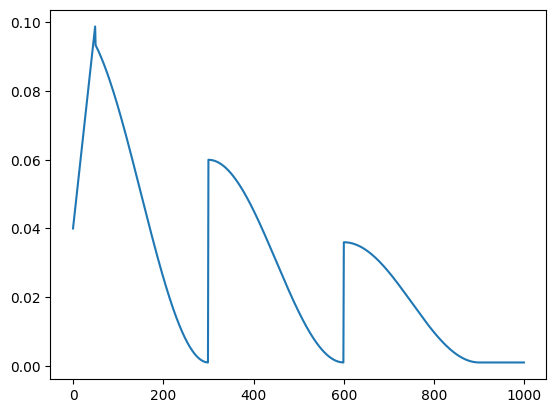

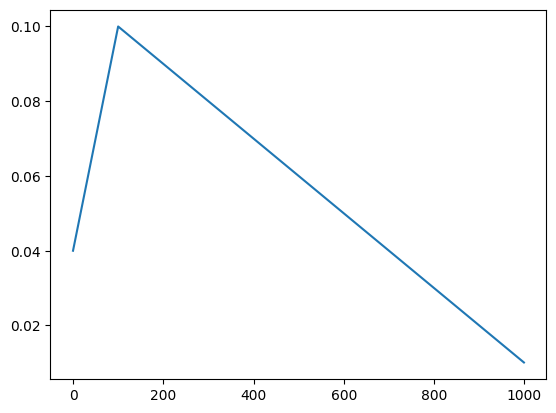

In [7]:

fn = fn_schedule_cosine_with_warmpup_decay_timm(100,
                                                num_steps_per_epoch=10, num_epochs_per_cycle=30,num_warmup_epochs=5, cycle_decay=0.6, min_lr=0.01)
plot_lr_step_schedule(fn, 0.1, 100, 10)
fn = fn_schedule_linear_with_warmup(10, 100, 100)
plot_lr_step_schedule(fn, 0.1, 100, 10)

## LitModel

In [8]:
#|export
def print_example():
    str = """
#---- HYPER
EPOCHS = 30
LR = 1e-4
BZ = 8
GPUS = 1
NUM_WORKERS = 4            
STRATEGY = 'dp'
# --- INIT dataset
train_ds = #
val_ds = #

dl_train = torch.utils.data.DataLoader(train_ds, BZ, num_workers=NUM_WORKERS, shuffle=True)
dl_val = torch.utils.data.DataLoader(train_ds, BZ, num_workers=NUM_WORKERS, shuffle=False)
# ---- Lr scheduler
sched = fn_schedule_cosine_with_warmpup_decay_timm(
    num_epochs=EPOCHS,
    num_steps_per_epoch=len(dl_train),
    num_epochs_per_cycle=EPOCHS//2,
    min_lr=1/100,
    cycle_decay=0.7,
)
# --- Optimizer
optim = lambda params:torch.optim.Adam(params, lr=LR)

# ---- LitModel
class CustomLit(LitModel):
    def forward(self, batch):
        # Get loss

    def training_step(self, batch, idx):
        out = self.forward(batch)
        return out['loss']

    def validation_step(self, batch, idx):
        out = self.forward(batch)
        self.log('val/loss', out['loss'], prog_bar=True, on_epoch=True)

lit = CustomLit(model,create_optimizer_fn=optim,
                               create_lr_scheduler_fn=sched, loss_fn=nn.CrossEntropyLoss())    

#---------------- Train

trainer = get_trainer('trans_lit', EPOCHS, gpus=GPUS, overfit_batches=0.05,
                     monitor={'metric': 'val/loss', 'mode': 'min'}, strategy=STRATEGY)
trainer.fit(trans_lit, dl_train, dl_val)
    """
    print(str)


In [9]:
#|hide
print_example()


#---- HYPER
EPOCHS = 30
LR = 1e-4
BZ = 8
GPUS = 1
NUM_WORKERS = 4            
STRATEGY = 'dp'
# --- INIT dataset
train_ds = #
val_ds = #

dl_train = torch.utils.data.DataLoader(train_ds, BZ, num_workers=NUM_WORKERS, shuffle=True)
dl_val = torch.utils.data.DataLoader(train_ds, BZ, num_workers=NUM_WORKERS, shuffle=False)
# ---- Lr scheduler
sched = fn_schedule_cosine_with_warmpup_decay_timm(
    num_epochs=EPOCHS,
    num_steps_per_epoch=len(dl_train),
    num_epochs_per_cycle=EPOCHS//2,
    min_lr=1/100,
    cycle_decay=0.7,
)
# --- Optimizer
optim = lambda params:torch.optim.Adam(params, lr=LR)

# ---- LitModel
class CustomLit(LitModel):
    def forward(self, batch):
        # Get loss

    def training_step(self, batch, idx):
        out = self.forward(batch)
        return out['loss']

    def validation_step(self, batch, idx):
        out = self.forward(batch)
        self.log('val/loss', out['loss'], prog_bar=True, on_epoch=True)

lit = CustomLit(model,create_optimizer_fn=optim,
 

In [10]:
#|export
class LitModel(LightningModule):
    def __init__(self, model,
                 create_optimizer_fn=None,
                 create_lr_scheduler_fn=None,
                 loss_fn=nn.CrossEntropyLoss()
                ):

        super().__init__()
        store_attr()

    def configure_optimizers(self):
        """
            Setup optimizer and scheduler
        """
        assert self.create_optimizer_fn is not None

        optimizer = self.create_optimizer_fn(self.model.parameters())
        scheduler = get_scheduler(optimizer, self.create_lr_scheduler_fn)
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()
        self.log("val_loss", loss, rank_zero_only=True, prog_bar=True,
                 on_step=False, on_epoch=True)
        self.log("val_acc", accs, rank_zero_only=True, prog_bar=True,
                 on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.softmax(1).argmax(1)
        accs = (y == preds).float().mean()

        self.log("training_loss", loss, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)
        self.log("training_accuracy", accs, prog_bar=True,
                 rank_zero_only=True, on_epoch=True)
        return loss


# Export

In [13]:
from nbdev import nbdev_export
nbdev_export()